In [42]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as scistats
import torch
import torch.nn as nn
%matplotlib inline

# Create a heteroscedastic dataset

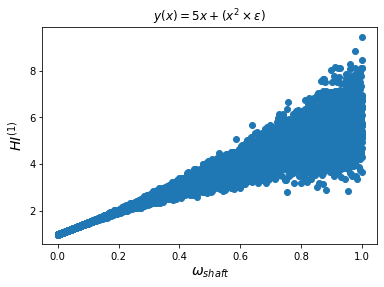

In [53]:
def bishop_sampler(n_samples):
    
    x_n = np.random.uniform(0, 1, n_samples)
    
    y_n = x_n + 0.3 * np.sin(2 * np.pi * x_n)
    noise = np.random.uniform(-0.1, 0.1, n_samples)
    
    return x_n, y_n + noise

def linear_sampler(n_samples, m = 5, c = 1, x_range = [0, 1]):
    
    x_n = np.random.uniform(x_range[0], x_range[1], n_samples)
    
    y_n = x_n * m + c 
    noise = np.random.randn(n_samples)
    heteroscedacity = x_n**2 * noise
    
    return x_n, y_n + heteroscedacity

omega_n, HI_n = linear_sampler(10000)#bishop_sampler(1000)

plt.figure()
plt.title(r"$y(x) = 5x + (x^2 \times \epsilon)$")
plt.scatter(omega_n, HI_n) 
plt.xlabel(r"$\omega_{shaft}$", fontsize = 14)
plt.ylabel(r"$HI^{(1)}$", fontsize = 14)
plt.show()

# Mixture Density Networks

In [107]:
class mu_layer(nn.Module):
    """
    Purpose of this is to allow the user to initialise the bias of the network by adding a nn.Parameter that the user can control.
    
    This nn.Parameter module is additive to the network output.
    """
    def __init__(self, n_features, n_hidden, n_components, initial_params = None):
        super(mu_layer, self).__init__()
        
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_components = n_components
        self.initial_params = initial_params
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        if self.initial_params is not None:
            assert self.initial_params.shape[0] == self.n_components, print("The initialisation tensor shape is incorrect in the mu_layer module.")

            self.bias = nn.Parameter(torch.from_numpy(self.initial_params.reshape(1, -1).astype(np.float32)), requires_grad = True)
            bias_flag = False
            
        else:
            self.bias = nn.Parameter(torch.zeros(1, int(self.n_components * self.n_features)), requires_grad = False)
            bias_flag = True
            
        self.mu_net = nn.Linear(in_features = self.n_hidden,
                                 out_features = int(self.n_components * self.n_features),
                                 bias = bias_flag)
         
    def forward(self, hidden_representation):
        
        return self.mu_net(hidden_representation) + self.bias

class sigma_layer(nn.Module):
    
    def __init__(self, n_features, n_hidden, n_components, initial_params = None):
        super(sigma_layer, self).__init__()
        
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_components = n_components
        self.initial_params = initial_params
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.activation = nn.Softplus()#lambda x: self._activation(x) + 1 + self.eps
        
        
        if self.initial_params is not None:
            assert self.initial_params.shape[0] == self.n_components, print("The initialisation tensor shape is incorrect in the mu_layer module.")
            
            #Need to adjust the bias to undo the softplus activation
            self.initial_params = np.log(np.exp(self.activation.beta * self.initial_params) - 1) / self.activation.beta
            
            #Need to adjust zero values
            #self.initial_params = initial_params * (initial_params > 0)
            
            self.bias = nn.Parameter(torch.from_numpy(self.initial_params.reshape(1, -1).astype(np.float32)), requires_grad = True)
            bias_flag = False
            
        else:
            self.bias = nn.Parameter(torch.zeros(1, int(self.n_components * self.n_features)), requires_grad = False)
            bias_flag = True
            
        self.sigma_net = nn.Linear(in_features = self.n_hidden,
                                 out_features = int(self.n_components * self.n_features),
                                 bias = bias_flag)
    
    def forward(self, hidden_representation):
        
        return self.activation(self.sigma_net(hidden_representation) + self.bias)

class pi_layer(nn.Module):
    
    def __init__(self, n_features, n_hidden, n_components):
        super(pi_layer, self).__init__()
        
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_components = n_components
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.activation = nn.Softmax(dim = 1)
            
        self.pi_net = nn.Linear(in_features = self.n_hidden,
                                 out_features = int(self.n_components),
                                 bias = True)
         
    def forward(self, hidden_representation):
        
        return self.activation(self.pi_net(hidden_representation)) #Bias does nothing, I am not sure how to initialise this well initially.
    
    

"""
initial_mu = np.array([[0.5], 
                       [0.2], 
                       [0.5]])
                       
initial_sigma = np.array([[0.1], 
                          [0.2],
                          [0.3]])

test_mu = mu_layer(1, 10, 3, initial_mu)
print(test_mu(torch.zeros(10, 10)), "\n\n")

test_sigma = sigma_layer(1, 10, 3, initial_sigma)
print(test_sigma(torch.zeros(10, 10)), "\n\n")
   
test_pi = pi_layer(1, 10, 3)
print(test_pi(torch.randn(10, 10)), "\n\n")    
""" 

'\n initial_mu = np.array([[0.5], \n                       [0.2], \n                       [0.5]])\n                       \ninitial_sigma = np.array([[0.1], \n                          [0.2],\n                          [0.3]])\n\ntest_mu = mu_layer(1, 10, 3, initial_mu)\nprint(test_mu(torch.zeros(10, 10)), "\n\n")\n\ntest_sigma = sigma_layer(1, 10, 3, initial_sigma)\nprint(test_sigma(torch.zeros(10, 10)), "\n\n")\n   \ntest_pi = pi_layer(1, 10, 3)\nprint(test_pi(torch.randn(10, 10)), "\n\n")    \n'

In [76]:
class MixtureDensityNetwork(nn.Module):
    
    def __init__(self, n_components, regression_type = 'polynomial', net_dict = None, init_params = 'kmeans', verbose = False):
        """
        This implementation is for a N-dimensional Mixture density network. I emphasise here that it is N-dimensional as I 
        try to improve the code to have better initialisations and a well-trained behaviour. 
        """
        super(MixtureDensityNetworks, self).__init__()
        
        self.n_components = n_components
        self.regression_type = regression_type
        self.net_dict = net_dict
        self.init_params = init_params
        self.verbose = verbose
    
    def initialise_model(self):
        pass
    
    def gaussian_likelihood(self, parameter_tuple, x, log_flag = True):
        
        if log_flag:
            pass
        
        else:
            pass
    
    def loss(self, net_output_tuple, x):
        pass
    
    def forward(self):
        pass
    
    def fit(self, X):
        pass
    
    def sample(self, n_samples):
        pass